In [1]:
import os
import pandas as pd
from TSB_AD.snn.params import running_params
from TSB_AD.snn.spikingjelly.encoders import HybridEncoder, RepeatEncoder, DynamicReceptiveEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from spikingjelly.activation_based.learning import STDPLearner
from spikingjelly.activation_based.functional import reset_net
import matplotlib.pyplot as plt
import time

### Data preparation

In [2]:
src_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/'
#src_file_path = '032_GHL_id_1_Sensor_tr_50000_1st_65001.csv'
#src_file_path = '034_GHL_id_3_Sensor_tr_50000_1st_122001.csv'
src_file_path = '051_GHL_id_20_Sensor_tr_50000_1st_75110.csv'
src_file_path = os.path.join(src_dir_path, src_file_path)

df = pd.read_csv(src_file_path)

data = df.iloc[:, :-1].values  # Assuming the first column is an index or timestamp
original_data = data.copy()
label = df.iloc[:, -1].values  # Assuming the last column is the label

length = data.shape[0]
features = data.shape[1]

# Length slicing
running_params['model']['window_size'] = window_size = 4000
idx_start = 73000
idx_end = idx_start + window_size

data = data[idx_start:idx_end, :]
label = label[idx_start:idx_end]

# Channel slicing
single_channel = False
if single_channel:
    target_channel = 0
    data = data[:, target_channel].reshape(-1, 1)

# Tensor conversion
tensor_data = torch.tensor(data, dtype=torch.float32)

In [3]:
print(f"Data shape after slicing: {tensor_data.shape}")

Data shape after slicing: torch.Size([4000, 19])


### Encoder instance

In [4]:
# Hybrid
hybrid_encoder = HybridEncoder(local_running_params=running_params, num_raw_features=1 if single_channel else features)

# Repeat
repeat_encoder = RepeatEncoder(local_running_params=running_params, output_size=running_params['ParallelSNNModel']['num_enc_features'])

# Receptive
receptive_encoder = DynamicReceptiveEncoder(local_running_params=running_params, num_raw_features=1 if single_channel else features, num_enc_features=running_params['ParallelSNNModel']['num_enc_features'])

In [5]:
print(hybrid_encoder.conv.weight.shape)

torch.Size([8, 19, 3])


### STDP instance

In [6]:
def f_weight(x):
    return torch.clamp(x, -1, 1.)

stdp_learners = []
s_stdp_learner = STDPLearner(step_mode='m',
                           synapse=hybrid_encoder.conv,
                           sn=hybrid_encoder.s_psn,
                           tau_pre=2., tau_post=100.,
                           f_pre=f_weight, f_post=f_weight,)

f_stdp_learner = STDPLearner(step_mode='m',
                           synapse=hybrid_encoder.conv,
                           sn=hybrid_encoder.f_psn,
                           tau_pre=2., tau_post=100.,
                           f_pre=f_weight, f_post=f_weight,)

n_stdp_learner = STDPLearner(step_mode='m',
                           synapse=hybrid_encoder.conv,
                           sn=hybrid_encoder.n_psn,
                           tau_pre=2., tau_post=100.,
                           f_pre=f_weight, f_post=f_weight,)
stdp_learners = [s_stdp_learner, f_stdp_learner, n_stdp_learner]

optimizer_stdp = optim.SGD(hybrid_encoder.parameters(), lr=0.1, momentum=0.)

In [7]:
print(s_stdp_learner.synapse.weight.shape)

torch.Size([8, 19, 3])


### STDP Learning

In [8]:
inputs = tensor_data.unsqueeze(0)  # 1, 2000, 1 (B, L, C)

hybrid_encoder.train()

simulation_steps = 1

time_start = time.time()
for step in range(simulation_steps):
    optimizer_stdp.zero_grad()

    post_spks = hybrid_encoder(inputs)

    '''
    for i in range(len(stdp_learners)):
        stdp_learners[i].step(on_grad=True)
    optimizer_stdp.step()
    '''
    
    reset_net(hybrid_encoder)
    
    '''for i in range(len(stdp_learners)):
        stdp_learners[i].reset()'''
hybrid_time = time.time() - time_start

In [9]:
post_spks.shape

torch.Size([1, 4, 8, 4000])

In [10]:
post_spks = post_spks.reshape(-1, window_size)
time_start = time.time()
repeat_out = repeat_encoder(inputs)
repeat_time = time.time() - time_start
time_start = time.time()
output = receptive_encoder(inputs)
receptive_time = time.time() - time_start

In [11]:
print(f"Hybrid time: {hybrid_time:.4f} s, Repeat time: {repeat_time:.4f} s, Receptive time: {receptive_time:.4f} s")

Hybrid time: 0.0672 s, Repeat time: 0.0240 s, Receptive time: 0.0069 s


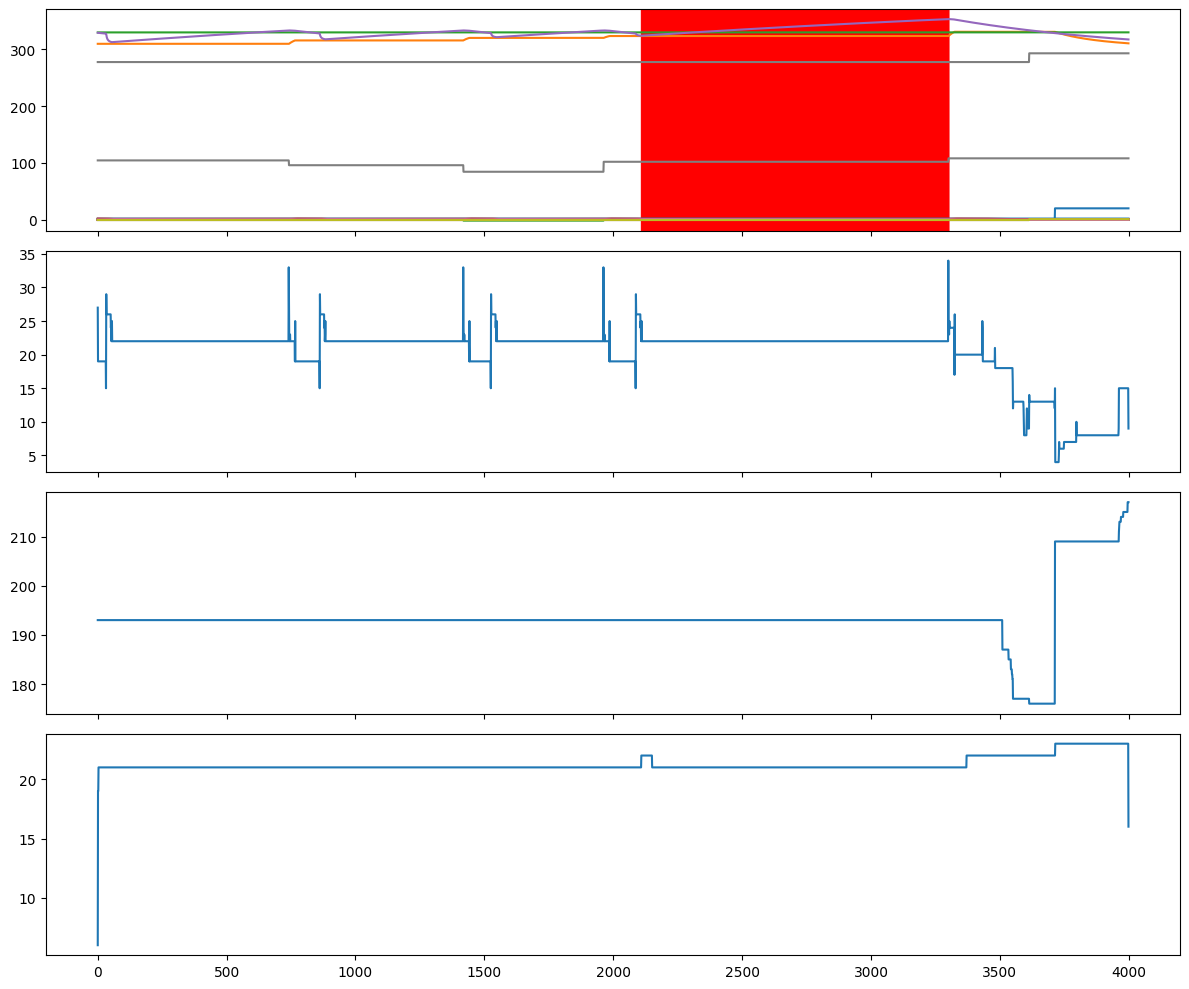

In [12]:
viz_post_spks = post_spks.sum(0).detach().numpy()
viz_repeat_out = repeat_out.reshape(-1, window_size).sum(0).detach().numpy()
viz_output = output.squeeze(0).squeeze(0).sum(0).detach().numpy()

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
if single_channel:
    axes[0].plot(original_data[idx_start:idx_end, target_channel], label='Original Channel')
else:
    for i in range(features):
        axes[0].plot(data[:, i], label=f'Channel {i}')
for t in range(len(label)):
    if label[t] == 1:
        axes[0].axvspan(t - 0.5, t + 0.5, color='red', alpha=0.9)
axes[1].plot(viz_post_spks)
axes[2].plot(viz_repeat_out)
axes[3].plot(viz_output)
plt.tight_layout()
plt.show()